### Elderly Fall Detection
#### Programmer: Mostafa Lotfi

This notebook is related to a project named "Elderly Fall Detection".
In this notebook I tried to create a Recurrent Neural Network (RNN) model to predict elderly Fall Detection using
acceleration signal obtained from phone accelerometer.
The dataset I used contains 17 classes (9 Daily Activities and 8 Fallings). Bellow you can see all the classes:

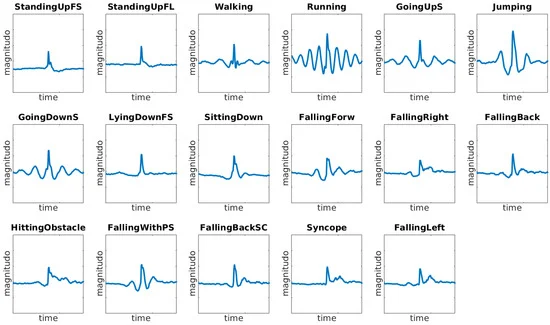




Totally there are 11771 samples. Each sample is 3 seconds with a sampling rate of 0.02 seconds. You can see https://www.mdpi.com/2076-3417/7/10/1101 for more details about the dataset.

In the following, Firstly I preprocessed the data. Then I made a LSTM model and trained that using the data. The objective is to predict the person has fallen or not.

In [1]:
# Importing libraries if they are installed, unless install them.
try:
    import scipy
    import numpy as np
    from sklearn.utils import shuffle
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix, classification_report
    from keras.models import Sequential
    from keras.layers import LSTM, Dense
    from keras.callbacks import EarlyStopping
    from joblib import dump
    import matplotlib.pyplot as plt
    import os
    
    print("modules imported!")
except ModuleNotFoundError:
    !pip install numpy scikit-learn tensorflow matplotlib
    
    print("Modules installed")

modules imported!


In [2]:
# decreasing sampling frequency respect to the sampling rate in the real-time state.
# In real-time state we could get data every 0.01 seconds. Therefore this is no necessary to decrease sampling frequency here
# but for better accuracy in training step, we decrease this to 0.5.
FREQ_DECREASE_RATIO = 1/10

In [3]:
input_data = scipy.io.loadmat('files/acc_data.mat')
output_data = scipy.io.loadmat('files/acc_labels.mat')
print(input_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'acc_data'])


In [4]:
# There are 11771 samples (rows in x and y). each sample consists of 3 seconds with sampling rate of 0.02 seconds.
# There are 453 columns (in x variable). [0, 150] are accelerations in the x direction.
# [151, 301] are for y and [302, 452] for z directions.
x = input_data['acc_data']
y = output_data['acc_labels'][:, 0]    # Column number 1 is the class number.
print(x.shape, y.shape)

(11771, 453) (11771,)


In [5]:
# Since probably old men can't run or jump, we remove those samples from data.
run_jump = (y == 4) | (y == 6)
x = np.delete(x, run_jump, 0)
y = np.delete(y, run_jump)
print(x.shape, y.shape)

(9040, 453) (9040,)


In [6]:
# Chaning all classes to 0 or 1 (hass fallen or not)
x0 = x[y <= 9]
x1 = x[y > 9]
print(x0.shape, x1.shape)

(4848, 453) (4192, 453)


In [7]:
# Equalizing data after shuffling
lower = min(x0.shape[0], x1.shape[0])

x0 = shuffle(x0)
x1 = shuffle(x1)

x0 = x0[:lower]
x1 = x1[:lower]

x = np.concatenate([x0, x1], 0)
y = np.array([0] * lower + [1] * lower).reshape((-1, 1))

print(x.shape, y.shape)

(8384, 453) (8384, 1)


In [8]:
# To standardize the data we should rearrange the data consecutively in each direction.
n_smp = x.shape[0]
batch_len = x.shape[1] // 3

for (i, smp) in enumerate(x):
    smp_x = smp[:batch_len]
    smp_y = smp[batch_len:-batch_len]
    smp_z = smp[-batch_len:]
    if i == 0:
        xx = smp_x
        xy = smp_y
        xz = smp_z
    else:
        xx = np.concatenate((xx, smp_x))
        xy = np.concatenate((xy, smp_y))
        xz = np.concatenate((xz, smp_z))

print(xx.shape, xy.shape, xz.shape)

(1265984,) (1265984,) (1265984,)


In [9]:
# Make standizer
scaler = StandardScaler()

xx = xx.reshape((-1, 1))
xy = xy.reshape((-1, 1))
xz = xz.reshape((-1, 1))

x_series = np.concatenate((xx, xy, xz), 1)

x_nrm = scaler.fit_transform(x_series)

In [10]:
# Rearrange the data to a format that LSTM model could accept
x = []
sampling_step = round(1/FREQ_DECREASE_RATIO)
for i in range(n_smp):
    x.append(np.concatenate((
        x_nrm[i*batch_len:(i+1)*batch_len, 0][::sampling_step].reshape((-1, 1)),
        x_nrm[i*batch_len:(i+1)*batch_len, 1][::sampling_step].reshape((-1, 1)),
        x_nrm[i*batch_len:(i+1)*batch_len, 2][::sampling_step].reshape((-1, 1))), 1))

x = np.array(x)
print(x.shape)

(8384, 16, 3)


In [11]:
# Spliting data to train and test
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, random_state=42)

In [12]:
# Stop training after 4 epochs of no improvement.
cb = EarlyStopping(patience=5, restore_best_weights=True)

In [13]:
# A simple RNN model (LSTM)
model = Sequential()

model.add(LSTM(128, input_shape=x_train.shape[1:], return_sequences=True))

model.add(LSTM(64))

model.add(Dense(64))

model.add(Dense(32))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16, 128)           67584     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 123,265
Trainable params: 123,265
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
# Training the model
results = model.fit(x_train, y_train, epochs=64, validation_data=(x_val, y_val), callbacks=cb)

Epoch 1/64
210/210 [==============================] - 9s 24ms/step - loss: 0.2698 - accuracy: 0.8773 - val_loss: 0.1693 - val_accuracy: 0.9326
Epoch 2/64
210/210 [==============================] - 4s 20ms/step - loss: 0.1457 - accuracy: 0.9408 - val_loss: 0.1239 - val_accuracy: 0.9451
Epoch 3/64
210/210 [==============================] - 4s 20ms/step - loss: 0.1081 - accuracy: 0.9586 - val_loss: 0.1269 - val_accuracy: 0.9493
Epoch 4/64
210/210 [==============================] - 4s 21ms/step - loss: 0.0982 - accuracy: 0.9612 - val_loss: 0.0903 - val_accuracy: 0.9595
Epoch 5/64
210/210 [==============================] - 4s 21ms/step - loss: 0.0797 - accuracy: 0.9688 - val_loss: 0.0871 - val_accuracy: 0.9642
Epoch 6/64
210/210 [==============================] - 4s 21ms/step - loss: 0.0652 - accuracy: 0.9751 - val_loss: 0.1218 - val_accuracy: 0.9481
Epoch 7/64
210/210 [==============================] - 4s 21ms/step - loss: 0.0651 - accuracy: 0.9757 - val_loss: 0.0551 - val_accuracy: 0.9779

In [15]:
yhat_train = model.predict(x_train).round()
yhat_val = model.predict(x_val).round()

53/53 [==============================] - 0s 9ms/step


In [16]:
print("Confusion Matrix for Train Data")
print(confusion_matrix(y_train, yhat_train))
print("Confusion Matrix for Validation Data")
print(confusion_matrix(y_val, yhat_val))
print("Classification Report for Train Data")
print(classification_report(y_train, yhat_train))
print("Classification Report for Validation Data")
print(classification_report(y_val, yhat_val))

Confusion Matrix for Train Data
[[3338   10]
 [   2 3357]]
Confusion Matrix for Validation Data
[[835   9]
 [  1 832]]
Classification Report for Train Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3348
           1       1.00      1.00      1.00      3359

    accuracy                           1.00      6707
   macro avg       1.00      1.00      1.00      6707
weighted avg       1.00      1.00      1.00      6707

Classification Report for Validation Data
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       844
           1       0.99      1.00      0.99       833

    accuracy                           0.99      1677
   macro avg       0.99      0.99      0.99      1677
weighted avg       0.99      0.99      0.99      1677



In [17]:
# Save model and standizer
files = os.listdir('./')
MODELS_DIR = 'models'
if 'models' not in files:
    os.mkdir(MODELS_DIR)
model.save(MODELS_DIR+'/model.h5')
dump(scaler, MODELS_DIR+'/scaler.bin')

['models/scaler.bin']

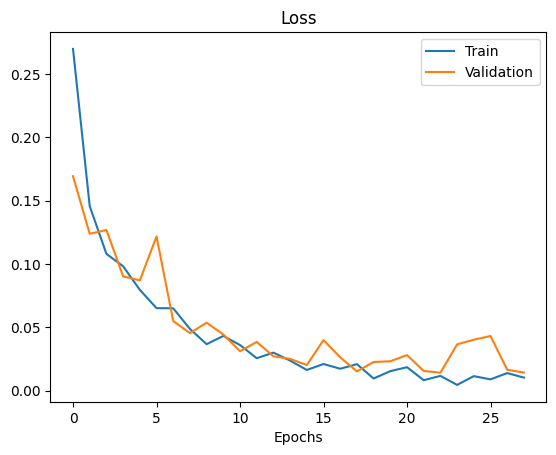

In [18]:
plt.plot(results.history['loss'], label='Train')
plt.plot(results.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

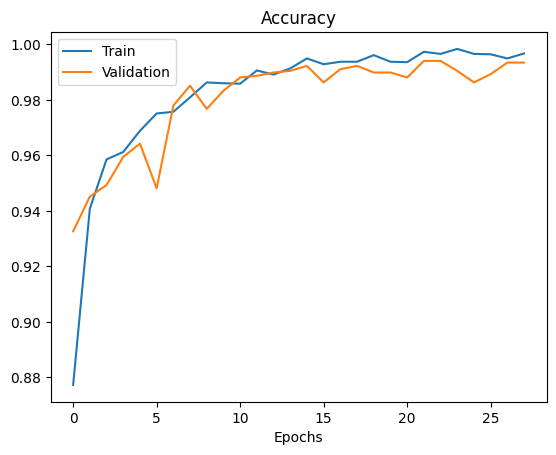

In [19]:
plt.plot(results.history['accuracy'], label='Train')
plt.plot(results.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()